In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm
import time
np.random.seed(42)

def run_classifier_model(model, X_train, y_train, X_test, y_test, 
                        scoring='accuracy', n_repeats=5, n_jobs=-1, **model_params):
    """
    Run a classifier model with cross-validation
    
    Parameters:
    -----------
    model : sklearn classifier class or instance
    X_train, y_train, X_test, y_test : training and test data
    scoring : str, scoring metric for CV ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')
    n_repeats : int, number of CV repeats
    n_jobs : int, parallel jobs
    **model_params : additional model parameters
    
    Returns:
    --------
    tuple: (mean_cv_score, std_cv_score, train_score, test_score)
    """
    
    # Instantiate the model if a class is provided
    if isinstance(model, type):
        model = model(**model_params)
    
    # Use StratifiedKFold for classification to maintain class balance
    cv_scores = cross_val_score(
        model, X_train, y_train,
        scoring=scoring,
        cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=42),
        n_jobs=n_jobs
    )
    
    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)
    
    # Fit the model on the full training set
    model.fit(X_train, y_train)
    
    # Compute training and testing scores
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    # Calculate the appropriate metric
    if scoring == 'accuracy':
        train_score = accuracy_score(y_train, train_preds)
        test_score = accuracy_score(y_test, test_preds)
    elif scoring == 'precision':
        train_score = precision_score(y_train, train_preds, average='binary')
        test_score = precision_score(y_test, test_preds, average='binary')
    elif scoring == 'recall':
        train_score = recall_score(y_train, train_preds, average='binary')
        test_score = recall_score(y_test, test_preds, average='binary')
    elif scoring == 'f1':
        train_score = f1_score(y_train, train_preds, average='binary')
        test_score = f1_score(y_test, test_preds, average='binary')
    elif scoring == 'roc_auc':
        # For ROC-AUC, we need probabilities
        if hasattr(model, 'predict_proba'):
            train_probs = model.predict_proba(X_train)[:, 1]
            test_probs = model.predict_proba(X_test)[:, 1]
            train_score = roc_auc_score(y_train, train_probs)
            test_score = roc_auc_score(y_test, test_probs)
        else:
            # Fallback to decision function or predictions
            train_score = roc_auc_score(y_train, train_preds)
            test_score = roc_auc_score(y_test, test_preds)
    else:
        # Default to accuracy
        train_score = accuracy_score(y_train, train_preds)
        test_score = accuracy_score(y_test, test_preds)
    
    return mean_cv_score, std_cv_score, train_score, test_score

def sweep_classifier_parameter(model,
                              Parameters,
                              param,
                              parameter_list,
                              X_train,
                              y_train,
                              X_test,
                              y_test,
                              scoring='accuracy',
                              verbose=True,
                              n_iter_no_change=None,
                              delta=0.001,
                              n_jobs=-1,
                              n_repeats=5,
                              return_score=False):
    """
    Sweep a parameter for a classification model
    
    Parameters:
    -----------
    model : sklearn classifier class
    Parameters : dict, base parameters for the model
    param : str, parameter name to sweep
    parameter_list : list, values to test for the parameter
    X_train, y_train, X_test, y_test : data splits
    scoring : str, metric to optimize ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')
    verbose : bool, whether to show plots
    n_iter_no_change : int, early stopping patience
    delta : float, minimum improvement threshold
    n_jobs : int, parallel jobs
    n_repeats : int, CV repeats
    return_score : bool, whether to return the best score separately
    
    Returns:
    --------
    dict: Updated parameters with best value (without score_found)
    float: Best score (only if return_score=True)
    """
    
    start = time.time()
    Parameters = Parameters.copy()
    
    cv_scores, std_cvs, train_scores, test_scores = [], [], [], []
    no_improve_count = 0
    
    # For classification, higher scores are better (opposite of MSE)
    best_score = -np.inf
    
    print(f"Sweeping {param} with {len(parameter_list)} values using {scoring} metric...")
    
    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        Parameters[param] = p
        P_temp = Parameters.copy()
        # Remove score_found if present
        P_temp.pop('score_found', None)
        
        try:
            cv_score, std_cv, train_score, test_score = run_classifier_model(
                model=model,
                X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                scoring=scoring,
                n_repeats=n_repeats,
                n_jobs=n_jobs,
                **P_temp
            )
            
            cv_scores.append(cv_score)
            std_cvs.append(std_cv)
            train_scores.append(train_score)
            test_scores.append(test_score)
            
            # Early-stopping logic (higher is better for classification)
            if cv_score > best_score + delta:
                best_score = cv_score
                no_improve_count = 0
            else:
                no_improve_count += 1
            
            if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
                print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
                break
                
        except Exception as e:
            print(f"Error with {param}={p}: {e}")
            # Add NaN values to maintain list consistency
            cv_scores.append(np.nan)
            std_cvs.append(np.nan)
            train_scores.append(np.nan)
            test_scores.append(np.nan)
    
    # Identify best parameter (ignoring NaN values)
    valid_scores = [score for score in cv_scores if not np.isnan(score)]
    if not valid_scores:
        raise ValueError("No valid scores computed!")
    
    max_cv_score = max(valid_scores)
    max_index = cv_scores.index(max_cv_score)
    best_param = parameter_list[max_index]
    Parameters[param] = best_param
    
    # FIXED: Remove score_found before returning
    Parameters.pop('score_found', None)

    if verbose:
        # Prepare for plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
        
        # We only need as many parameter values as we actually computed
        partial_param_list = parameter_list[:len(cv_scores)]
        
        # Check if our parameter list is Boolean
        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        if is_boolean:
            x_vals = list(range(len(partial_param_list)))
            x_labels = [str(val) for val in partial_param_list]
        else:
            x_vals = partial_param_list
            x_labels = partial_param_list
        
        # ----- First plot: Scores -----
        ax1.set_title(f"{scoring.upper()} vs {param}")
        
        # Plot lines (filter out NaN values)
        valid_indices = [i for i, score in enumerate(cv_scores) if not np.isnan(score)]
        valid_x_vals = [x_vals[i] for i in valid_indices]
        valid_cv_scores = [cv_scores[i] for i in valid_indices]
        valid_train_scores = [train_scores[i] for i in valid_indices]
        valid_test_scores = [test_scores[i] for i in valid_indices]
        
        ax1.plot(valid_x_vals, valid_cv_scores, marker='o', 
                label=f"CV {scoring.upper()}", color='blue', linewidth=2)
        ax1.plot(valid_x_vals, valid_train_scores, marker='s', 
                label=f"Train {scoring.upper()}", color='green', alpha=0.7)
        ax1.plot(valid_x_vals, valid_test_scores, marker='^', linestyle='--',
                label=f"Test {scoring.upper()}", color='orange', alpha=0.7)
        
        # Highlight best point
        if max_index < len(x_vals):
            ax1.scatter([x_vals[max_index]], [max_cv_score], 
                       marker='*', s=200, label=f"Best CV {scoring.upper()}", 
                       color='red', zorder=5)
        
        ax1.set_ylabel(f"{scoring.upper()} Score")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Set y-axis limits to reasonable range for classification metrics
        if scoring in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
            ax1.set_ylim(0, 1.05)
        
        # ----- Second plot: CV Standard Deviation -----
        ax2.set_title(f"CV Standard Deviation vs {param}")
        valid_std_cvs = [std_cvs[i] for i in valid_indices]
        ax2.plot(valid_x_vals, valid_std_cvs, marker='o', 
                label=f"CV {scoring.upper()} Std", color='purple')
        ax2.set_xlabel(param)
        ax2.set_ylabel("Standard Deviation")
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # If we are using boolean x-values, set custom ticks
        if is_boolean:
            for ax in [ax1, ax2]:
                ax.set_xticks(x_vals)
                ax.set_xticklabels(x_labels)
        
        plt.tight_layout()
        plt.show()
        
        end = time.time()
        print(f"Execution Time: {time.strftime('%H:%M:%S', time.gmtime(end - start))}")
        print(f"Best {param}: {best_param}")
        print(f"Best CV {scoring}: {max_cv_score:.4f}")
    
    if return_score:
        return Parameters, max_cv_score
    else:
        return Parameters

# Specialized version for injury prediction (minority class focus)
def sweep_injury_classifier_parameter(model,
                                     Parameters,
                                     param,
                                     parameter_list,
                                     X_train,
                                     y_train,
                                     X_test,
                                     y_test,
                                     custom_scorer=None,
                                     verbose=True,
                                     n_iter_no_change=None,
                                     delta=0.001,
                                     n_jobs=-1,
                                     n_repeats=3,
                                     return_score=False):
    """
    Specialized parameter sweep for injury prediction with minority class focus
    
    Parameters:
    -----------
    custom_scorer : callable, custom scoring function (e.g., minority class accuracy)
    return_score : bool, whether to return the best score separately
    
    Returns:
    --------
    dict: Updated parameters with best value (without score_found)
    float: Best score (only if return_score=True)
    """
    
    def minority_class_accuracy(y_true, y_pred):
        """Calculate accuracy on minority class (injuries) only"""
        class_1_mask = (y_true == 1)
        if np.sum(class_1_mask) == 0:
            return 0.0
        return accuracy_score(y_true[class_1_mask], y_pred[class_1_mask])
    
    if custom_scorer is None:
        # Use minority class accuracy as default for injury prediction
        def custom_scorer_func(estimator, X, y):
            y_pred = estimator.predict(X)
            return minority_class_accuracy(y, y_pred)
        custom_scorer = custom_scorer_func
    
    # Adapt the main function to use custom scorer
    start = time.time()
    Parameters = Parameters.copy()
    
    cv_scores, std_cvs, train_scores, test_scores = [], [], [], []
    no_improve_count = 0
    best_score = -np.inf
    
    print(f"Sweeping {param} with minority class focus...")
    
    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        Parameters[param] = p
        P_temp = Parameters.copy()
        P_temp.pop('score_found', None)
        
        try:
            # Instantiate model
            if isinstance(model, type):
                model_instance = model(**P_temp)
            else:
                model_instance = model
                model_instance.set_params(**P_temp)
            
            # Cross-validation with custom scorer
            cv_scores_fold = cross_val_score(
                model_instance, X_train, y_train,
                scoring=custom_scorer,
                cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=42),
                n_jobs=n_jobs
            )
            
            mean_cv = np.mean(cv_scores_fold)
            std_cv = np.std(cv_scores_fold)
            
            # Fit and evaluate on train/test
            model_instance.fit(X_train, y_train)
            train_pred = model_instance.predict(X_train)
            test_pred = model_instance.predict(X_test)
            
            train_score = minority_class_accuracy(y_train, train_pred)
            test_score = minority_class_accuracy(y_test, test_pred)
            
            cv_scores.append(mean_cv)
            std_cvs.append(std_cv)
            train_scores.append(train_score)
            test_scores.append(test_score)
            
            # Early stopping
            if mean_cv > best_score + delta:
                best_score = mean_cv
                no_improve_count = 0
            else:
                no_improve_count += 1
            
            if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
                print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
                break
                
        except Exception as e:
            print(f"Error with {param}={p}: {e}")
            cv_scores.append(np.nan)
            std_cvs.append(np.nan)
            train_scores.append(np.nan)
            test_scores.append(np.nan)
    
    # Find best parameter
    valid_scores = [score for score in cv_scores if not np.isnan(score)]
    if not valid_scores:
        raise ValueError("No valid scores computed!")
    
    max_cv_score = max(valid_scores)
    max_index = cv_scores.index(max_cv_score)
    best_param = parameter_list[max_index]
    Parameters[param] = best_param
    
    # FIXED: Remove score_found before returning
    Parameters.pop('score_found', None)

    if verbose:
        # Plotting code similar to above but with "Minority Class Accuracy" labels
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
        
        partial_param_list = parameter_list[:len(cv_scores)]
        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        
        if is_boolean:
            x_vals = list(range(len(partial_param_list)))
            x_labels = [str(val) for val in partial_param_list]
        else:
            x_vals = partial_param_list
            x_labels = partial_param_list
        
        valid_indices = [i for i, score in enumerate(cv_scores) if not np.isnan(score)]
        valid_x_vals = [x_vals[i] for i in valid_indices]
        valid_cv_scores = [cv_scores[i] for i in valid_indices]
        valid_train_scores = [train_scores[i] for i in valid_indices]
        valid_test_scores = [test_scores[i] for i in valid_indices]
        
        ax1.set_title(f"Minority Class Accuracy vs {param}")
        ax1.plot(valid_x_vals, valid_cv_scores, marker='o', 
                label="CV Minority Accuracy", color='blue', linewidth=2)
        ax1.plot(valid_x_vals, valid_train_scores, marker='s', 
                label="Train Minority Accuracy", color='green', alpha=0.7)
        ax1.plot(valid_x_vals, valid_test_scores, marker='^', linestyle='--',
                label="Test Minority Accuracy", color='orange', alpha=0.7)
        
        if max_index < len(x_vals):
            ax1.scatter([x_vals[max_index]], [max_cv_score], 
                       marker='*', s=200, label="Best CV Score", 
                       color='red', zorder=5)
        
        ax1.set_ylabel("Minority Class Accuracy")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(0, 1.05)
        
        ax2.set_title(f"CV Standard Deviation vs {param}")
        valid_std_cvs = [std_cvs[i] for i in valid_indices]
        ax2.plot(valid_x_vals, valid_std_cvs, marker='o', 
                label="CV Std", color='purple')
        ax2.set_xlabel(param)
        ax2.set_ylabel("Standard Deviation")
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        if is_boolean:
            for ax in [ax1, ax2]:
                ax.set_xticks(x_vals)
                ax.set_xticklabels(x_labels)
        
        plt.tight_layout()
        plt.show()
        
        end = time.time()
        print(f"Execution Time: {time.strftime('%H:%M:%S', time.gmtime(end - start))}")
        print(f"Best {param}: {best_param}")
        print(f"Best CV Minority Accuracy: {max_cv_score:.4f}")
    
    if return_score:
        return Parameters, max_cv_score
    else:
        return Parameters

# Example usage functions
def example_usage():
    """
    Example of how to use the classification parameter sweep
    """
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neighbors import KNeighborsClassifier
    
    # Example 1: Basic classification parameter sweep
    base_params = {'random_state': 42}
    n_estimators_list = [50, 100, 150, 200, 250]
    
    # Option 1: Get only parameters (default behavior)
    # best_params = sweep_classifier_parameter(
    #     model=RandomForestClassifier,
    #     Parameters=base_params,
    #     param='n_estimators',
    #     parameter_list=n_estimators_list,
    #     X_train=X_train, y_train=y_train,
    #     X_test=X_test, y_test=y_test,
    #     scoring='f1',
    #     n_repeats=3,
    #     verbose=True
    # )
    
    # Option 2: Get both parameters and best score
    # best_params, best_score = sweep_classifier_parameter(
    #     model=RandomForestClassifier,
    #     Parameters=base_params,
    #     param='n_estimators',
    #     parameter_list=n_estimators_list,
    #     X_train=X_train, y_train=y_train,
    #     X_test=X_test, y_test=y_test,
    #     scoring='f1',
    #     n_repeats=3,
    #     verbose=True,
    #     return_score=True
    # )
    
    # Example 2: Injury prediction with minority class focus
    knn_params = {}
    k_values = list(range(1, 21))
    
    # best_knn_params = sweep_injury_classifier_parameter(
    #     model=KNeighborsClassifier,
    #     Parameters=knn_params,
    #     param='n_neighbors',
    #     parameter_list=k_values,
    #     X_train=X_train, y_train=y_train,
    #     X_test=X_test, y_test=y_test,
    #     n_repeats=3,
    #     verbose=True
    # )
    
    print("Example usage templates ready!")
    return "Ready to use!"

dataset 1

In [198]:
# Need to re-apply SMOTE to the properly scaled data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler


# training sets
X_train = pd.read_csv('scripts/play_surface/motion_train_X_original.csv')
y_train = pd.read_csv('scripts/play_surface/motion_train_y_original.csv')['injured']

# holdout sets
X_holdout = pd.read_csv('scripts/play_surface/motion_holdout_X.csv')
y_holdout = pd.read_csv('scripts/play_surface/motion_holdout_y.csv')['injured']


scaler = StandardScaler()
# Fit the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)
X_holdout_scaled = scaler.transform(X_holdout)

print(f"\nCheck standard deviation of test vs holdout:")
print(f"Training mean: {X_train_scaled.mean():.6f}, std: {X_train_scaled.std():.6f}")
print(f"Holdout mean: {X_holdout_scaled.mean():.6f}, std: {X_holdout_scaled.std():.6f}")

# Apply SMOTE to the freshly scaled data
undersample = RandomUnderSampler(sampling_strategy=0.01)
oversample = SMOTE(sampling_strategy=0.1)
pipeline = ImbPipeline([('undersample', undersample), ('oversample', oversample)])

# apply pipeline
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train_scaled, y_train)



# Split the resampled training data into train/validation for parameter tuning
from sklearn.model_selection import train_test_split

X_param_train, X_param_val, y_param_train, y_param_val = train_test_split(
    X_train_resampled, y_train_resampled, 
    test_size=0.2, random_state=42, stratify=y_train_resampled
)


Check standard deviation of test vs holdout:
Training mean: -0.000000, std: 1.000000
Holdout mean: 0.000789, std: 1.000330


In [199]:
from sklearn.neighbors import KNeighborsClassifier

first_run = run_classifier_model(
    model=KNeighborsClassifier(n_neighbors=5),
    X_train=X_param_train, 
    y_train=y_param_train,
    X_test=X_param_val, 
    y_test=y_param_val,
    scoring='f1',
    n_repeats=5,
    verbose=True
)
print(f"First run results: {first_run}")

First run results: (np.float64(0.7388072384228555), np.float64(0.017089606828530907), 0.824332712600869, 0.772093023255814)


Sweeping n_neighbors with 5 values using f1 metric...


Sweeping n_neighbors: 100%|██████████| 5/5 [00:01<00:00,  3.68it/s]


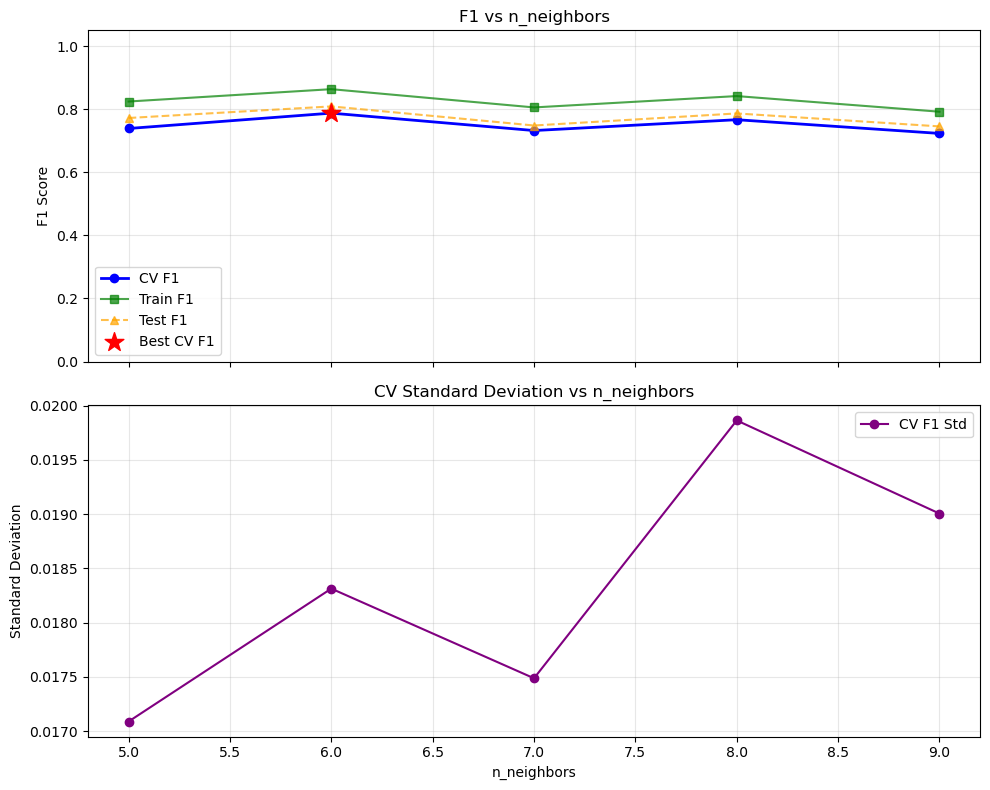

Execution Time: 00:00:01
Best n_neighbors: 6
Best CV f1: 0.7875
Best KNN parameters: {'n_neighbors': 6}, Best F1 Score: 0.7875


In [200]:
knn_params = {'n_neighbors': 5}
k_values = list(range(5, 10))

best_knn_params, best_score = sweep_classifier_parameter(
    model=KNeighborsClassifier,
    Parameters=knn_params,
    param='n_neighbors',
    parameter_list=k_values,
    X_train=X_param_train, 
    y_train=y_param_train,
    X_test=X_param_val,
    y_test=y_param_val,
    scoring='f1',
    n_repeats=5,
    verbose=True,
    return_score=True
)
print(f"Best KNN parameters: {best_knn_params}, Best F1 Score: {best_score:.4f}")

next_model = KNeighborsClassifier(**best_knn_params)

Sweeping weights with 2 values using f1 metric...


Sweeping weights: 100%|██████████| 2/2 [00:00<00:00,  5.10it/s]


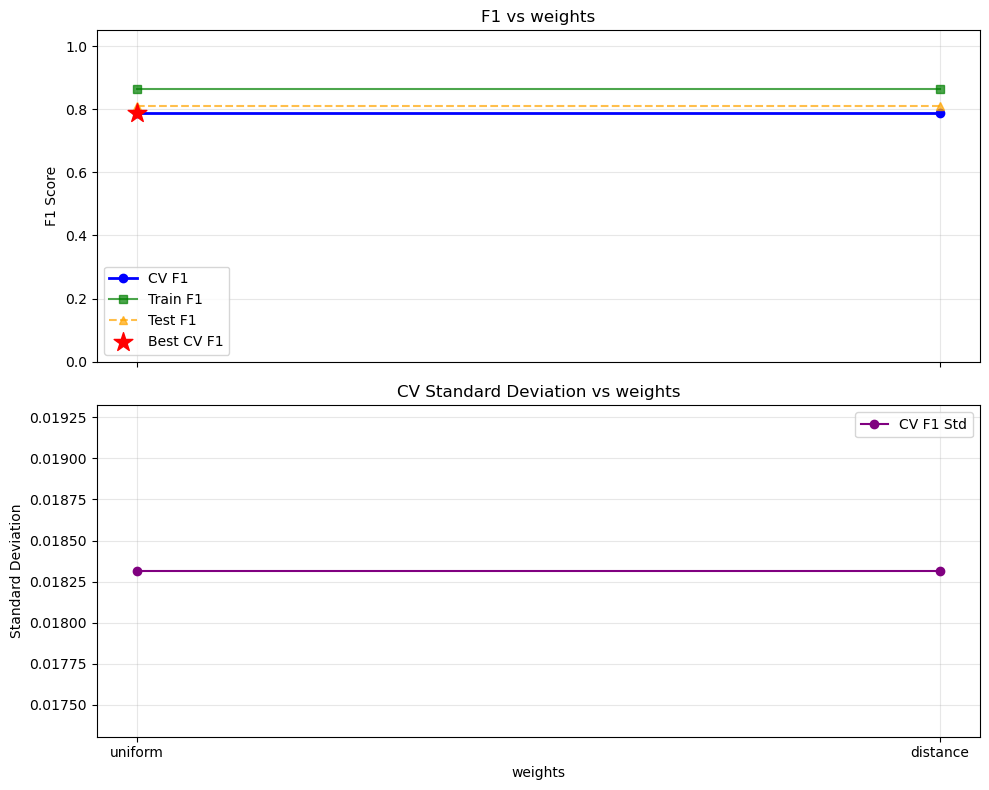

Execution Time: 00:00:00
Best weights: uniform
Best CV f1: 0.7875
Best KNN parameters after weight sweep: {'n_neighbors': 6, 'weights': 'uniform'}, Best F1 Score: 0.7875


In [201]:
weight_values = ['uniform', 'distance']

best_knn_params, best_score = sweep_classifier_parameter(
    model=next_model,
    Parameters=best_knn_params,
    param='weights',
    parameter_list=weight_values,  
    X_train=X_param_train, 
    y_train=y_param_train,
    X_test=X_param_val,
    y_test=y_param_val,
    scoring='f1',
    n_repeats=5,
    verbose=True,
    return_score=True
)

print(f"Best KNN parameters after weight sweep: {best_knn_params}, Best F1 Score: {best_score:.4f}")
next_model = KNeighborsClassifier(**best_knn_params)

Sweeping metric with 3 values using f1 metric...


Sweeping metric: 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]


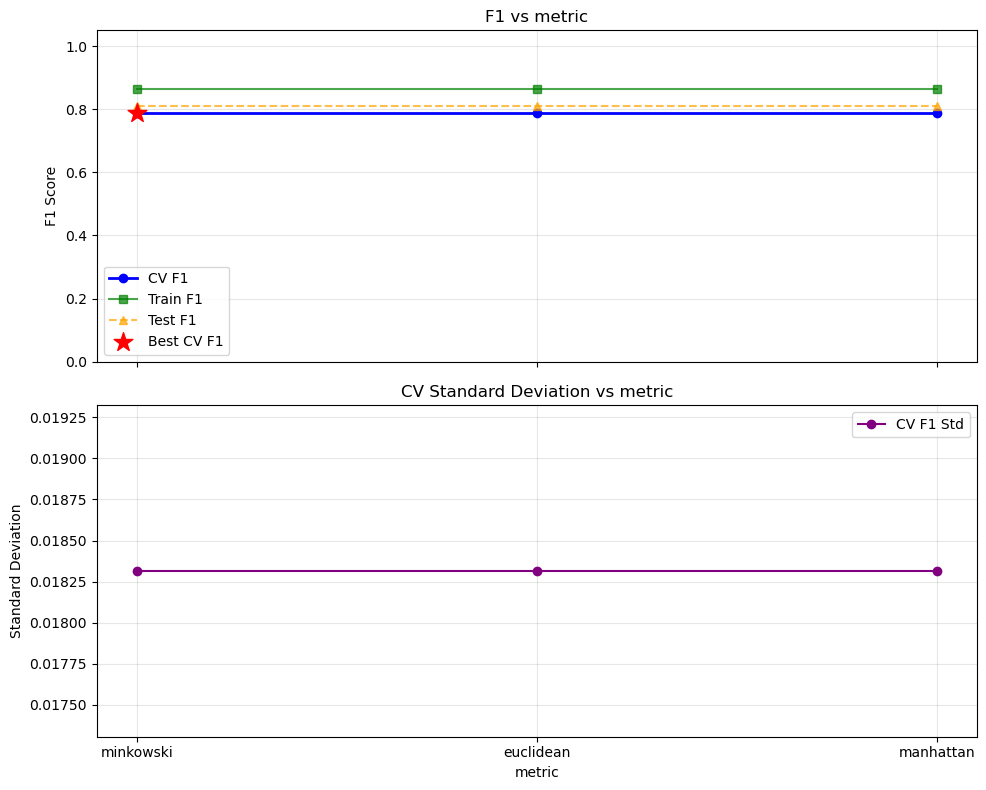

Execution Time: 00:00:00
Best metric: minkowski
Best CV f1: 0.7875
Best KNN parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'minkowski'}, Best F1 Score: 0.7875


In [202]:
metrics = ['minkowski', 'euclidean', 'manhattan']

best_knn_params, best_score = sweep_classifier_parameter(
    model=next_model,
    Parameters=best_knn_params,
    param='metric',
    parameter_list=metrics,
    X_train=X_param_train, 
    y_train=y_param_train,
    X_test=X_param_val,
    y_test=y_param_val,
    scoring='f1',
    n_repeats=5,
    verbose=True,
    return_score=True
)
print(f"Best KNN parameters: {best_knn_params}, Best F1 Score: {best_score:.4f}")
next_model = KNeighborsClassifier(**best_knn_params)

Sweeping leaf_size with 5 values using f1 metric...


Sweeping leaf_size: 100%|██████████| 5/5 [00:01<00:00,  4.91it/s]


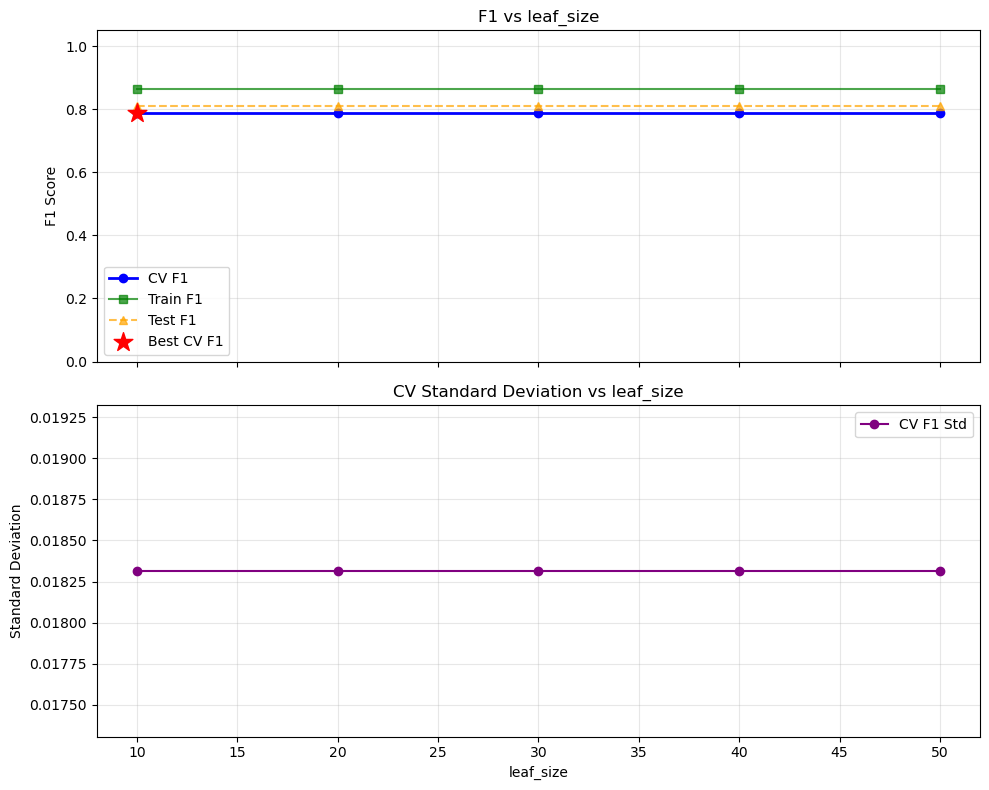

Execution Time: 00:00:01
Best leaf_size: 10
Best CV f1: 0.7875
Best KNN parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'minkowski', 'leaf_size': 10}, Best F1 Score: 0.7875


In [203]:
leaf_sizes = [10, 20, 30, 40, 50]
best_knn_params, best_score = sweep_classifier_parameter(
    model=next_model,
    Parameters=best_knn_params,
    param='leaf_size',
    parameter_list=leaf_sizes,
    X_train=X_param_train, 
    y_train=y_param_train,
    X_test=X_param_val,
    y_test=y_param_val,
    scoring='f1',
    n_repeats=5,
    verbose=True,
    return_score=True
)
print(f"Best KNN parameters: {best_knn_params}, Best F1 Score: {best_score:.4f}")
next_model = KNeighborsClassifier(**best_knn_params)

Sweeping algorithm with 4 values using f1 metric...


Sweeping algorithm: 100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


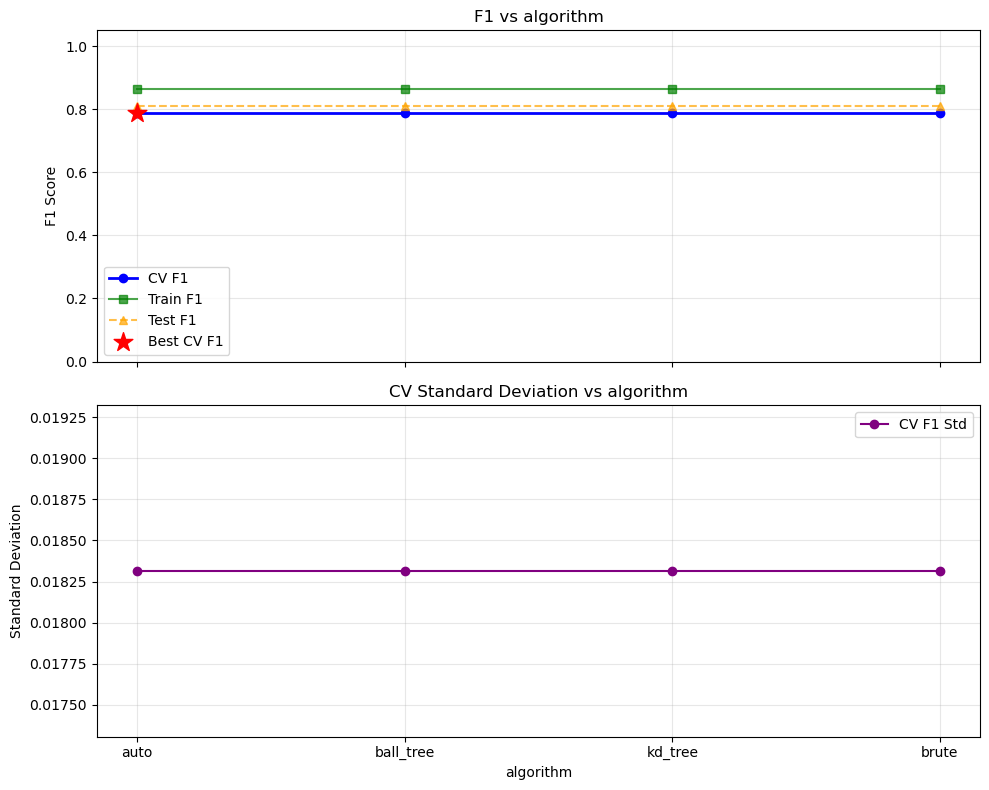

Execution Time: 00:00:00
Best algorithm: auto
Best CV f1: 0.7875
Best KNN parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'minkowski', 'leaf_size': 10, 'algorithm': 'auto'}, Best F1 Score: 0.7875


In [204]:
algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']
best_knn_params, best_score = sweep_classifier_parameter(
    model=next_model,
    Parameters=best_knn_params,
    param='algorithm',
    parameter_list=algorithms,
    X_train=X_param_train, 
    y_train=y_param_train,
    X_test=X_param_val,
    y_test=y_param_val,
    scoring='f1',
    n_repeats=5,
    verbose=True,
    return_score=True
)
print(f"Best KNN parameters: {best_knn_params}, Best F1 Score: {best_score:.4f}")
next_model = KNeighborsClassifier(**best_knn_params)

In [206]:
next_model.fit(X_param_train, y_param_train)

KNeighborsClassifier(leaf_size=10, n_neighbors=6)

In [207]:
from sklearn.metrics import confusion_matrix
# Evaluate on holdout set
y_final_pred = next_model.predict(X_holdout_scaled)
holdout_accuracy = accuracy_score(y_holdout, y_final_pred)
holdout_confusion = confusion_matrix(y_holdout, y_final_pred)
print(f"Holdout Set Accuracy: {holdout_accuracy:.4f}")
print("Holdout Confusion Matrix:")
print(holdout_confusion)

Holdout Set Accuracy: 0.9525
Holdout Confusion Matrix:
[[50853  2518]
 [   20     1]]


### Residual Analysis

In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class InjuryResidualAnalyzer:
    """
    Comprehensive residual analysis for NFL injury classification models
    """
    
    def __init__(self, model, X_train, X_test, y_train, y_test, 
                 feature_names=None, original_data=None):
        """
        Initialize the analyzer
        
        Parameters:
        -----------
        model : trained sklearn classifier
        X_train, X_test : numpy arrays or pandas DataFrames
            Scaled/preprocessed feature data
        y_train, y_test : numpy arrays
            Target variables (0=no injury, 1=injury)
        feature_names : list, optional
            Names of features (helpful for interpretation)
        original_data : pd.DataFrame, optional
            Original unscaled data with all columns for additional analysis
        """
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.feature_names = feature_names
        self.original_data = original_data
        
        # Generate predictions and probabilities
        self.y_train_pred = model.predict(X_train)
        self.y_test_pred = model.predict(X_test)
        
        if hasattr(model, 'predict_proba'):
            self.y_train_proba = model.predict_proba(X_train)[:, 1]
            self.y_test_proba = model.predict_proba(X_test)[:, 1]
        else:
            self.y_train_proba = None
            self.y_test_proba = None
        
        # Identify error types
        self._classify_errors()
    
    def _classify_errors(self):
        """Classify different types of prediction errors"""
        
        # Training set errors
        self.train_false_positives = (self.y_train == 0) & (self.y_train_pred == 1)
        self.train_false_negatives = (self.y_train == 1) & (self.y_train_pred == 0)
        self.train_true_positives = (self.y_train == 1) & (self.y_train_pred == 1)
        self.train_true_negatives = (self.y_train == 0) & (self.y_train_pred == 0)
        
        # Test set errors  
        self.test_false_positives = (self.y_test == 0) & (self.y_test_pred == 1)
        self.test_false_negatives = (self.y_test == 1) & (self.y_test_pred == 0)
        self.test_true_positives = (self.y_test == 1) & (self.y_test_pred == 1)
        self.test_true_negatives = (self.y_test == 0) & (self.y_test_pred == 0)
    
    def print_error_summary(self):
        """Print a summary of prediction errors"""
        
        print(" PREDICTION ERROR SUMMARY")
        print("=" * 60)
        
        # Test set analysis (most important)
        print("TEST SET ERRORS:")
        print(f"  False Positives (predicted injury, no injury):  {self.test_false_positives.sum():,}")
        print(f"  False Negatives (missed injuries):             {self.test_false_negatives.sum():,}")
        print(f"  True Positives (correctly predicted injuries): {self.test_true_positives.sum():,}")
        print(f"  True Negatives (correctly predicted safe):     {self.test_true_negatives.sum():,}")
        
        # Calculate rates
        total_actual_injuries = self.y_test.sum()
        total_actual_safe = len(self.y_test) - total_actual_injuries
        
        if total_actual_injuries > 0:
            miss_rate = self.test_false_negatives.sum() / total_actual_injuries
            print(f"\n  Miss Rate (% of injuries missed): {miss_rate:.1%}")
        
        if total_actual_safe > 0:
            false_alarm_rate = self.test_false_positives.sum() / total_actual_safe  
            print(f"  False Alarm Rate (% of safe predicted as injury): {false_alarm_rate:.1%}")
        
        print(f"\nTRAINING SET ERRORS:")
        print(f"  False Positives: {self.train_false_positives.sum():,}")
        print(f"  False Negatives: {self.train_false_negatives.sum():,}")
        
        # Overfitting check
        train_accuracy = (self.y_train == self.y_train_pred).mean()
        test_accuracy = (self.y_test == self.y_test_pred).mean()
        print(f"\nOVERFITTING CHECK:")
        print(f"  Training Accuracy: {train_accuracy:.4f}")
        print(f"  Test Accuracy:     {test_accuracy:.4f}")
        print(f"  Difference:        {train_accuracy - test_accuracy:.4f}")
        
        if train_accuracy - test_accuracy > 0.05:
            print(" Possible overfitting detected!")
        else:
            print(" No significant overfitting")
    
    def analyze_missed_injuries(self, top_n=10):
        """Analyze the characteristics of missed injuries (false negatives)"""
        
        print(f"\nMISSED INJURY ANALYSIS (Top {top_n} insights)")
        print("=" * 60)
        
        if self.test_false_negatives.sum() == 0:
            print(" No missed injuries in test set!")
            return
        
        # Get false negative indices
        fn_indices = np.where(self.test_false_negatives)[0]
        
        print(f"Total missed injuries: {len(fn_indices)}")
        
        if self.y_test_proba is not None:
            fn_probabilities = self.y_test_proba[fn_indices]
            print(f"Prediction probabilities for missed injuries:")
            print(f"  Mean: {fn_probabilities.mean():.3f}")
            print(f"  Min:  {fn_probabilities.min():.3f}")
            print(f"  Max:  {fn_probabilities.max():.3f}")
            
            # Show the "closest calls" - missed injuries with highest probabilities
            if len(fn_probabilities) > 0:
                sorted_indices = np.argsort(fn_probabilities)[::-1]
                print(f"\nClosest calls (highest probabilities for missed injuries):")
                for i, idx in enumerate(sorted_indices[:5]):
                    actual_idx = fn_indices[idx]
                    prob = fn_probabilities[idx]
                    print(f"  {i+1}. Index {actual_idx}: probability = {prob:.3f}")
        
        # Feature analysis for missed injuries
        if self.feature_names is not None:
            print(f"\nFeature patterns in missed injuries:")
            self._analyze_feature_patterns(fn_indices, "missed injuries")
    
    def analyze_false_alarms(self, top_n=10):
        """Analyze the characteristics of false alarms (false positives)"""
        
        print(f"\n FALSE ALARM ANALYSIS (Top {top_n} insights)")
        print("=" * 60)
        
        if self.test_false_positives.sum() == 0:
            print(" No false alarms in test set!")
            return
        
        # Get false positive indices
        fp_indices = np.where(self.test_false_positives)[0]
        
        print(f"Total false alarms: {len(fp_indices)}")
        
        if self.y_test_proba is not None:
            fp_probabilities = self.y_test_proba[fp_indices]
            print(f"Prediction probabilities for false alarms:")
            print(f"  Mean: {fp_probabilities.mean():.3f}")
            print(f"  Min:  {fp_probabilities.min():.3f}")
            print(f"  Max:  {fp_probabilities.max():.3f}")
            
            # Show the most confident false alarms
            if len(fp_probabilities) > 0:
                sorted_indices = np.argsort(fp_probabilities)[::-1]
                print(f"\nMost confident false alarms:")
                for i, idx in enumerate(sorted_indices[:5]):
                    actual_idx = fp_indices[idx]
                    prob = fp_probabilities[idx]
                    print(f"  {i+1}. Index {actual_idx}: probability = {prob:.3f}")
        
        # Feature analysis for false alarms
        if self.feature_names is not None:
            print(f"\nFeature patterns in false alarms:")
            self._analyze_feature_patterns(fp_indices, "false alarms")
    
    def _analyze_feature_patterns(self, error_indices, error_type):
        """Analyze feature patterns for a specific type of error"""
        
        if len(error_indices) == 0:
            return
        
        # Get the features for error cases
        error_features = self.X_test[error_indices]
        
        # Compare to overall test set
        all_features = self.X_test
        
        print(f"\nFeature analysis for {error_type}:")
        
        # Calculate feature statistics
        feature_stats = []
        
        for i, feature_name in enumerate(self.feature_names):
            error_values = error_features[:, i]
            all_values = all_features[:, i]
            
            # Skip if all values are the same (no variance)
            if np.std(all_values) == 0:
                continue
            
            error_mean = np.mean(error_values)
            all_mean = np.mean(all_values)
            
            # Statistical test
            try:
                stat, p_value = stats.ttest_ind(error_values, all_values)
                
                feature_stats.append({
                    'feature': feature_name,
                    'error_mean': error_mean,
                    'overall_mean': all_mean,
                    'difference': error_mean - all_mean,
                    'relative_diff': (error_mean - all_mean) / (abs(all_mean) + 1e-10),
                    'p_value': p_value,
                    'significant': p_value < 0.05
                })
            except:
                continue
        
        # Sort by absolute relative difference
        feature_stats.sort(key=lambda x: abs(x['relative_diff']), reverse=True)
        
        # Show top distinctive features
        print(f"Most distinctive features for {error_type}:")
        for i, stat in enumerate(feature_stats[:10]):
            significance = "***" if stat['significant'] else ""
            direction = "higher" if stat['relative_diff'] > 0 else "lower"
            print(f"  {i+1:2d}. {stat['feature'][:25]:25s}: "
                  f"{stat['relative_diff']:+.1%} {direction} {significance}")
    
    def plot_probability_distributions(self):
        """Plot probability distributions for different prediction outcomes"""
        
        if self.y_test_proba is None:
            print("Model doesn't support probability predictions - skipping probability analysis")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle('Prediction Probability Distributions', fontsize=16)
        
        # True Negatives (correctly predicted no injury)
        tn_probs = self.y_test_proba[self.test_true_negatives]
        axes[0,0].hist(tn_probs, bins=30, alpha=0.7, color='green', edgecolor='black')
        axes[0,0].set_title(f'True Negatives (n={len(tn_probs):,})')
        axes[0,0].set_xlabel('Injury Probability')
        axes[0,0].set_ylabel('Frequency')
        axes[0,0].axvline(0.5, color='red', linestyle='--', alpha=0.7)
        
        # False Positives (incorrectly predicted injury)
        fp_probs = self.y_test_proba[self.test_false_positives]
        if len(fp_probs) > 0:
            axes[0,1].hist(fp_probs, bins=30, alpha=0.7, color='orange', edgecolor='black')
        axes[0,1].set_title(f'False Positives (n={len(fp_probs):,})')
        axes[0,1].set_xlabel('Injury Probability')
        axes[0,1].set_ylabel('Frequency')
        axes[0,1].axvline(0.5, color='red', linestyle='--', alpha=0.7)
        
        # False Negatives (missed injuries)
        fn_probs = self.y_test_proba[self.test_false_negatives]
        if len(fn_probs) > 0:
            axes[1,0].hist(fn_probs, bins=30, alpha=0.7, color='red', edgecolor='black')
        axes[1,0].set_title(f'False Negatives (n={len(fn_probs):,})')
        axes[1,0].set_xlabel('Injury Probability')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].axvline(0.5, color='red', linestyle='--', alpha=0.7)
        
        # True Positives (correctly predicted injury)
        tp_probs = self.y_test_proba[self.test_true_positives]
        if len(tp_probs) > 0:
            axes[1,1].hist(tp_probs, bins=30, alpha=0.7, color='blue', edgecolor='black')
        axes[1,1].set_title(f'True Positives (n={len(tp_probs):,})')
        axes[1,1].set_xlabel('Injury Probability')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].axvline(0.5, color='red', linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.show()
        
        # Summary statistics
        print("\nProbability Distribution Summary:")
        print(f"True Negatives - Mean: {tn_probs.mean():.3f}, Std: {tn_probs.std():.3f}")
        if len(fp_probs) > 0:
            print(f"False Positives - Mean: {fp_probs.mean():.3f}, Std: {fp_probs.std():.3f}")
        if len(fn_probs) > 0:
            print(f"False Negatives - Mean: {fn_probs.mean():.3f}, Std: {fn_probs.std():.3f}")
        if len(tp_probs) > 0:
            print(f"True Positives - Mean: {tp_probs.mean():.3f}, Std: {tp_probs.std():.3f}")
    
    def plot_confusion_matrix(self):
        """Plot confusion matrix with detailed labels"""
        
        cm = confusion_matrix(self.y_test, self.y_test_pred)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['No Injury', 'Injury'],
                   yticklabels=['No Injury', 'Injury'])
        plt.title('Confusion Matrix - Test Set')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        
        # Add performance metrics as text
        tn, fp, fn, tp = cm.ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        plt.text(0.5, -0.15, f'Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}', 
                transform=plt.gca().transAxes, ha='center', fontsize=12)
        
        plt.tight_layout()
        plt.show()
    
    def generate_error_report(self, save_path=None):
        """Generate a comprehensive error analysis report"""
        
        print(" COMPREHENSIVE RESIDUAL ANALYSIS REPORT")
        print("=" * 80)
        
        # Summary
        self.print_error_summary()
        
        # Detailed analysis
        self.analyze_missed_injuries()
        self.analyze_false_alarms()
        
        # Visualizations
        print(f"\n GENERATING VISUALIZATIONS...")
        self.plot_confusion_matrix()
        self.plot_probability_distributions()
        
        # Additional insights
        self._generate_insights()
        
        if save_path:
            print(f"\n💾 Report saved to: {save_path}")
    
    def _generate_insights(self):
        """Generate actionable insights from the analysis"""
        
        print(f"\n KEY INSIGHTS & RECOMMENDATIONS")
        print("=" * 60)
        
        # Miss rate analysis
        total_injuries = self.y_test.sum()
        missed_injuries = self.test_false_negatives.sum()
        
        if total_injuries > 0:
            miss_rate = missed_injuries / total_injuries
            
            if miss_rate > 0.3:
                print(" HIGH MISS RATE:")
                print(f"   - Missing {miss_rate:.1%} of actual injuries")
                print("   - Consider lowering classification threshold")
                print("   - May need more features or better feature engineering")
            elif miss_rate > 0.1:
                print("  MODERATE MISS RATE:")
                print(f"   - Missing {miss_rate:.1%} of actual injuries")
                print("   - Monitor threshold optimization")
            else:
                print(" LOW MISS RATE:")
                print(f"   - Only missing {miss_rate:.1%} of actual injuries")
        
        # False alarm analysis
        total_safe = len(self.y_test) - total_injuries
        false_alarms = self.test_false_positives.sum()
        
        if total_safe > 0:
            false_alarm_rate = false_alarms / total_safe
            
            if false_alarm_rate > 0.1:
                print("\n HIGH FALSE ALARM RATE:")
                print(f"   - {false_alarm_rate:.1%} false positive rate")
                print("   - Consider raising classification threshold")
                print("   - May indicate feature noise or overfitting")
            else:
                print(f"\n ACCEPTABLE FALSE ALARM RATE: {false_alarm_rate:.1%}")
        
        # Model confidence analysis
        if self.y_test_proba is not None:
            # Check prediction confidence
            confident_predictions = ((self.y_test_proba < 0.2) | (self.y_test_proba > 0.8)).sum()
            confidence_rate = confident_predictions / len(self.y_test_proba)
            
            print(f"\n MODEL CONFIDENCE:")
            print(f"   - {confidence_rate:.1%} of predictions are confident (prob < 0.2 or > 0.8)")
            
            if confidence_rate < 0.5:
                print("   - Model seems uncertain about many predictions")
                print("   - Consider ensemble methods or more data")

# Convenience function for quick analysis
def analyze_injury_model_errors(model, X_train, X_test, y_train, y_test, 
                               feature_names=None, original_data=None):
    """
    Quick function to run complete residual analysis
    
    Usage:
    ------
    analyze_injury_model_errors(
        model=trained_model,
        X_train=X_train_scaled, X_test=X_test_scaled,
        y_train=y_train, y_test=y_test,
        feature_names=['feature1', 'feature2', ...],
        original_data=original_df  # Optional
    )
    """
    
    analyzer = InjuryResidualAnalyzer(
        model=model,
        X_train=X_train, X_test=X_test,
        y_train=y_train, y_test=y_test,
        feature_names=feature_names,
        original_data=original_data
    )
    
    analyzer.generate_error_report()
    
    return analyzer

print("Injury Residual Analysis Tools Created!")
print("\nMain functions:")
print("  - InjuryResidualAnalyzer: Full analysis class")
print("  - analyze_injury_model_errors(): Quick analysis function")
print("\nUsage:")
print("  analyzer = analyze_injury_model_errors(model, X_train, X_test, y_train, y_test)")

Injury Residual Analysis Tools Created!

Main functions:
  - InjuryResidualAnalyzer: Full analysis class
  - analyze_injury_model_errors(): Quick analysis function

Usage:
  analyzer = analyze_injury_model_errors(model, X_train, X_test, y_train, y_test)


 COMPREHENSIVE RESIDUAL ANALYSIS REPORT
 PREDICTION ERROR SUMMARY
TEST SET ERRORS:
  False Positives (predicted injury, no injury):  2,518
  False Negatives (missed injuries):             20
  True Positives (correctly predicted injuries): 1
  True Negatives (correctly predicted safe):     50,853

  Miss Rate (% of injuries missed): 95.2%
  False Alarm Rate (% of safe predicted as injury): 4.7%

TRAINING SET ERRORS:
  False Positives: 206
  False Negatives: 3

OVERFITTING CHECK:
  Training Accuracy: 0.9714
  Test Accuracy:     0.9525
  Difference:        0.0189
 No significant overfitting

MISSED INJURY ANALYSIS (Top 10 insights)
Total missed injuries: 20
Prediction probabilities for missed injuries:
  Mean: 0.075
  Min:  0.000
  Max:  0.500

Closest calls (highest probabilities for missed injuries):
  1. Index 45972: probability = 0.500
  2. Index 6414: probability = 0.333
  3. Index 4759: probability = 0.333
  4. Index 34675: probability = 0.333
  5. Index 48963: probability = 0.000


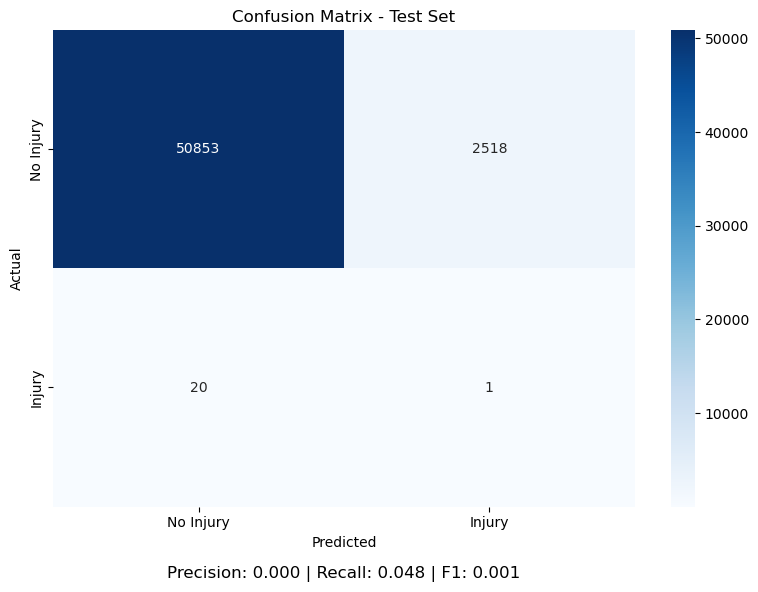

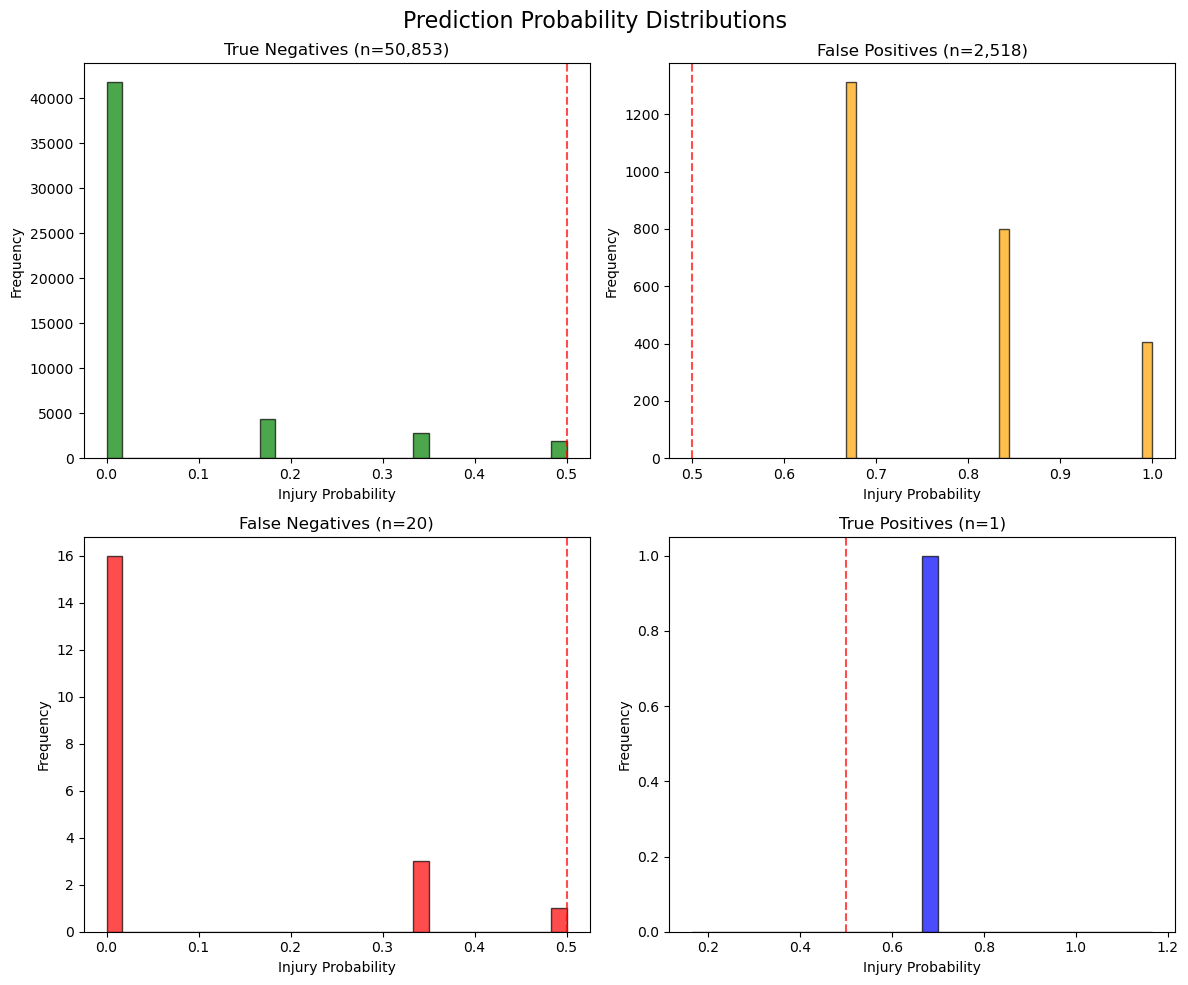


Probability Distribution Summary:
True Negatives - Mean: 0.052, Std: 0.124
False Positives - Mean: 0.773, Std: 0.124
False Negatives - Mean: 0.075, Std: 0.153
True Positives - Mean: 0.667, Std: 0.000

 KEY INSIGHTS & RECOMMENDATIONS
 HIGH MISS RATE:
   - Missing 95.2% of actual injuries
   - Consider lowering classification threshold
   - May need more features or better feature engineering

 ACCEPTABLE FALSE ALARM RATE: 4.7%

 MODEL CONFIDENCE:
   - 88.6% of predictions are confident (prob < 0.2 or > 0.8)


In [209]:
analyze_injury_model_errors(
    model=next_model,
    X_train=X_param_train, X_test=X_holdout_scaled,
    y_train=y_param_train, y_test=y_holdout,
    feature_names=X_holdout.columns.tolist()
)

dataset 2

In [212]:
# training sets
X_train = pd.read_csv('scripts/punt_analytics/motion_train_X_original.csv')
y_train = pd.read_csv('scripts/punt_analytics/motion_train_y_original.csv')['concussed']

# holdout sets
X_holdout = pd.read_csv('scripts/punt_analytics/motion_holdout_X.csv')
y_holdout = pd.read_csv('scripts/punt_analytics/motion_holdout_y.csv')['concussed']


scaler = StandardScaler()
# Fit the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)
X_holdout_scaled = scaler.transform(X_holdout)

print(f"\nCheck standard deviation of test vs holdout:")
print(f"Training mean: {X_train_scaled.mean():.6f}, std: {X_train_scaled.std():.6f}")
print(f"Holdout mean: {X_holdout_scaled.mean():.6f}, std: {X_holdout_scaled.std():.6f}")

# Apply SMOTE to the freshly scaled data
undersample = RandomUnderSampler(sampling_strategy=0.01)
oversample = SMOTE(sampling_strategy=0.1)
pipeline = ImbPipeline([('undersample', undersample), ('oversample', oversample)])

# apply pipeline
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train_scaled, y_train)



# Split the resampled training data into train/validation for parameter tuning
from sklearn.model_selection import train_test_split

X_param_train, X_param_val, y_param_train, y_param_val = train_test_split(
    X_train_resampled, y_train_resampled, 
    test_size=0.2, random_state=42, stratify=y_train_resampled
)


Check standard deviation of test vs holdout:
Training mean: 0.000000, std: 1.000000
Holdout mean: 0.000436, std: 1.000054


Sweeping n_neighbors with minority class focus...


Sweeping n_neighbors: 100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


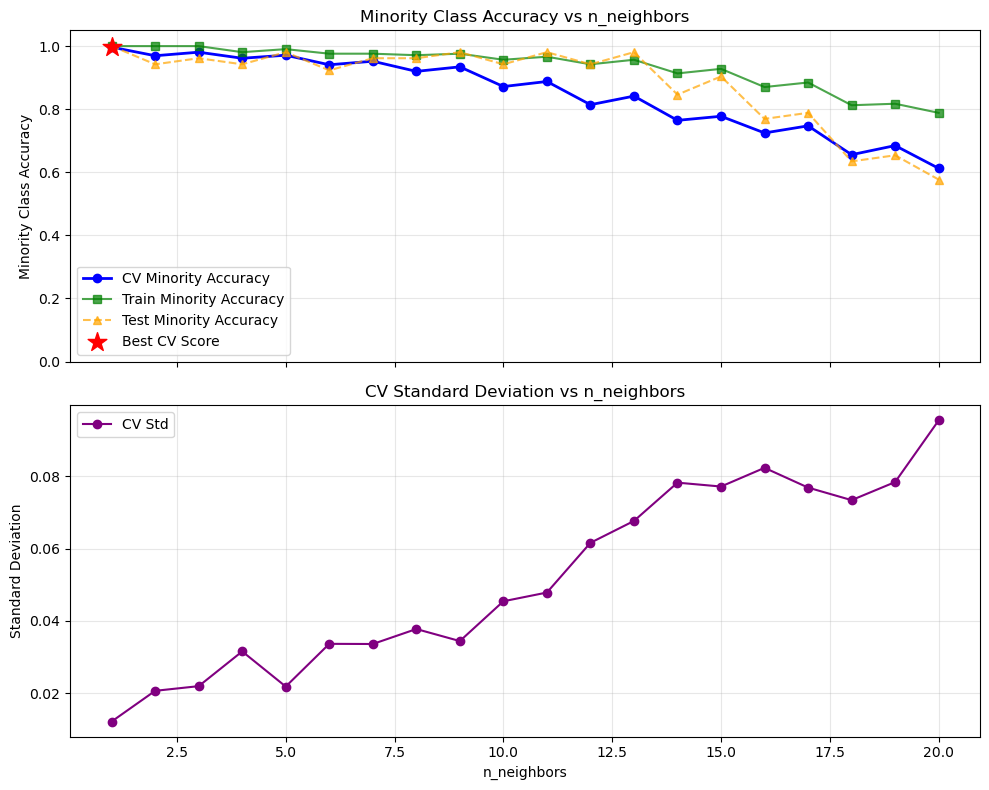

Execution Time: 00:00:02
Best n_neighbors: 1
Best CV Minority Accuracy: 0.9967
Best KNN parameters: {'n_neighbors': 1}, Best F1 Score: 0.9967


In [213]:
from sklearn.neighbors import KNeighborsClassifier

# Use your parameter sweep on the resampled training data
knn_params = {'n_neighbors': 5}  # Base parameters
k_values = list(range(1, 21))  # Range of K values to test

best_params, best_score = sweep_injury_classifier_parameter(
    model=KNeighborsClassifier,
    Parameters=knn_params,
    param='n_neighbors',
    parameter_list=k_values,
    X_train=X_param_train,  # Subset of resampled training data
    y_train=y_param_train,
    X_test=X_param_val,     # Validation split from resampled data
    y_test=y_param_val,
    n_repeats=3,
    verbose=True,
    return_score=True
)

print(f"Best KNN parameters: {best_params}, Best F1 Score: {best_score:.4f}")
next_model = KNeighborsClassifier(**best_params)

Sweeping weights with 2 values using accuracy metric...


Sweeping weights: 100%|██████████| 2/2 [00:00<00:00, 33.47it/s]


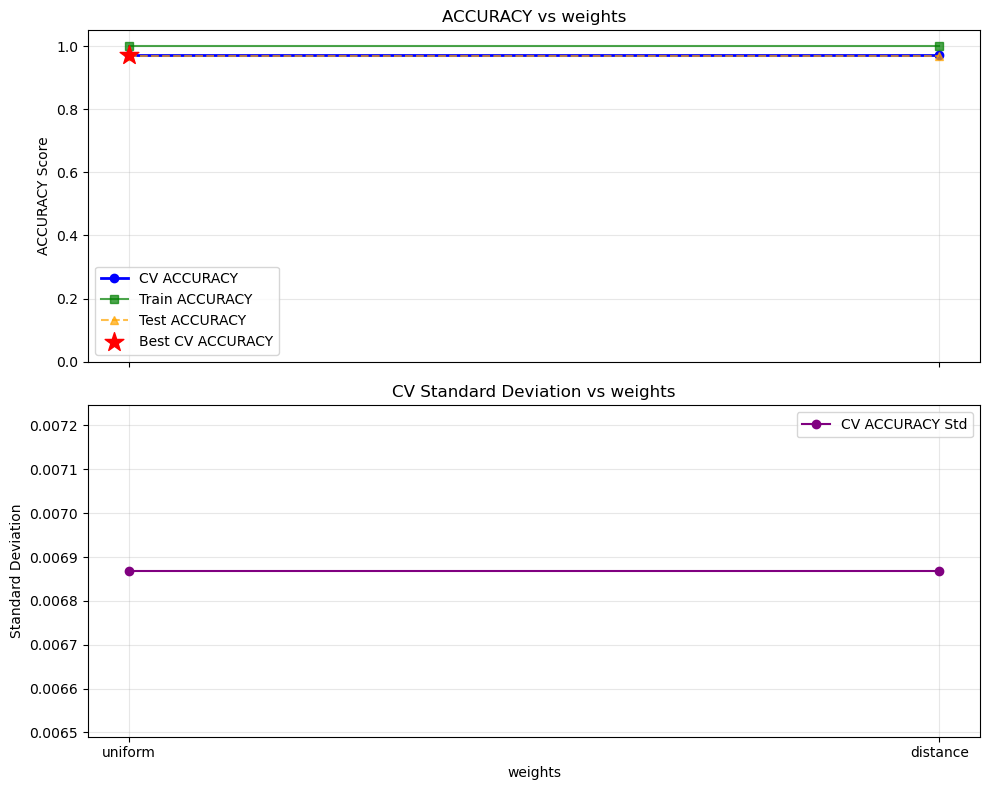

Execution Time: 00:00:00
Best weights: uniform
Best CV accuracy: 0.9733
Best KNN parameters after weight sweep: {'n_neighbors': 1, 'weights': 'uniform'}, Best F1 Score: 0.9733


In [214]:
weight_values = ['uniform', 'distance']

best_params, best_score = sweep_classifier_parameter(
    model=next_model,
    Parameters=best_params,
    param='weights',
    parameter_list=weight_values,  
    X_train=X_param_train, 
    y_train=y_param_train,
    X_test=X_param_val,
    y_test=y_param_val, 
    n_repeats=5,
    verbose=True,
    return_score=True
)

print(f"Best KNN parameters after weight sweep: {best_params}, Best F1 Score: {best_score:.4f}")
next_model = KNeighborsClassifier(**best_params)

Sweeping metric with minority class focus...


Sweeping metric: 100%|██████████| 4/4 [00:00<00:00, 20.45it/s]


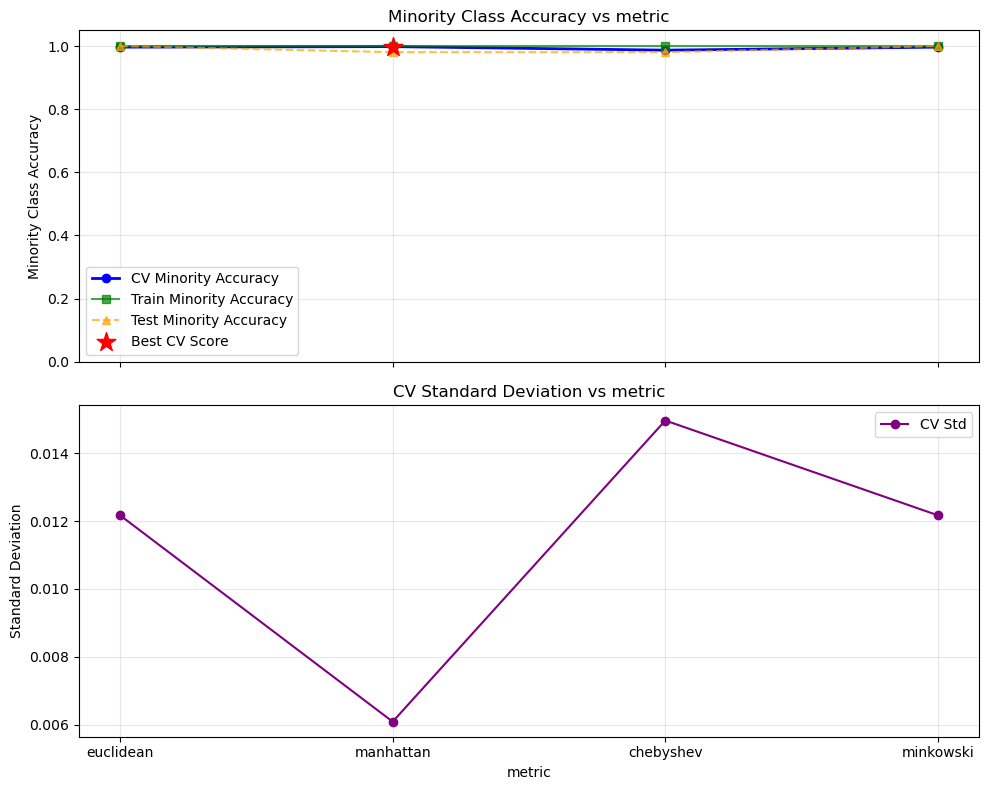

Execution Time: 00:00:00
Best metric: manhattan
Best CV Minority Accuracy: 0.9984
Best KNN parameters after weight sweep: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'manhattan'}, Best F1 Score: 0.9984


In [215]:
distance_metrics = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']

best_params, best_score = sweep_injury_classifier_parameter(
    model=next_model,
    Parameters=best_params,
    param='metric',
    parameter_list=distance_metrics,
    X_train=X_param_train,
    y_train=y_param_train,
    X_test=X_param_val,
    y_test=y_param_val,
    n_repeats=3,
    verbose=True,
    return_score=True)


print(f"Best KNN parameters after weight sweep: {best_params}, Best F1 Score: {best_score:.4f}")
next_model = KNeighborsClassifier(**best_params)

Sweeping leaf_size with 5 values using accuracy metric...


Sweeping leaf_size: 100%|██████████| 5/5 [00:00<00:00, 19.78it/s]


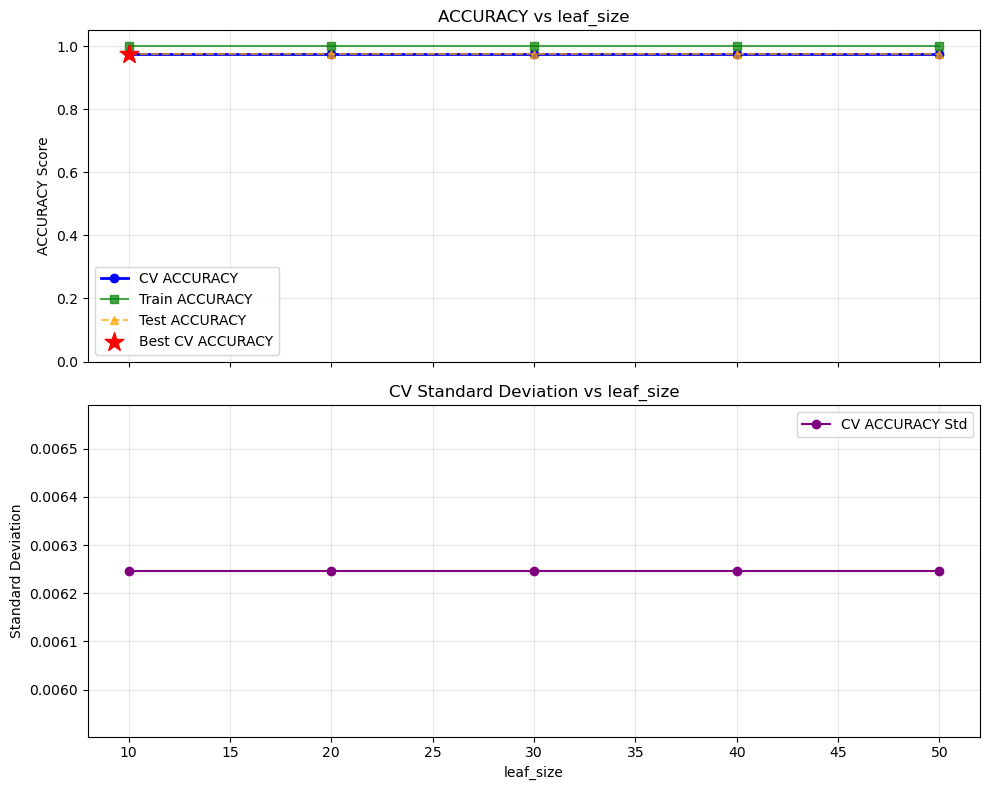

Execution Time: 00:00:00
Best leaf_size: 10
Best CV accuracy: 0.9741
Best KNN parameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'manhattan', 'leaf_size': 10}, Best F1 Score: 0.9741


In [216]:
leaf_sizes = [10, 20, 30, 40, 50]
best_params, best_score = sweep_classifier_parameter(
    model=next_model,
    Parameters=best_params,
    param='leaf_size',
    parameter_list=leaf_sizes,
    X_train=X_param_train, 
    y_train=y_param_train,
    X_test=X_param_val,
    y_test=y_param_val,
    n_repeats=5,
    verbose=True,
    return_score=True
)
print(f"Best KNN parameters: {best_params}, Best F1 Score: {best_score:.4f}")
next_model = KNeighborsClassifier(**best_params)

Sweeping algorithm with 4 values using accuracy metric...


Sweeping algorithm: 100%|██████████| 4/4 [00:00<00:00, 20.19it/s]


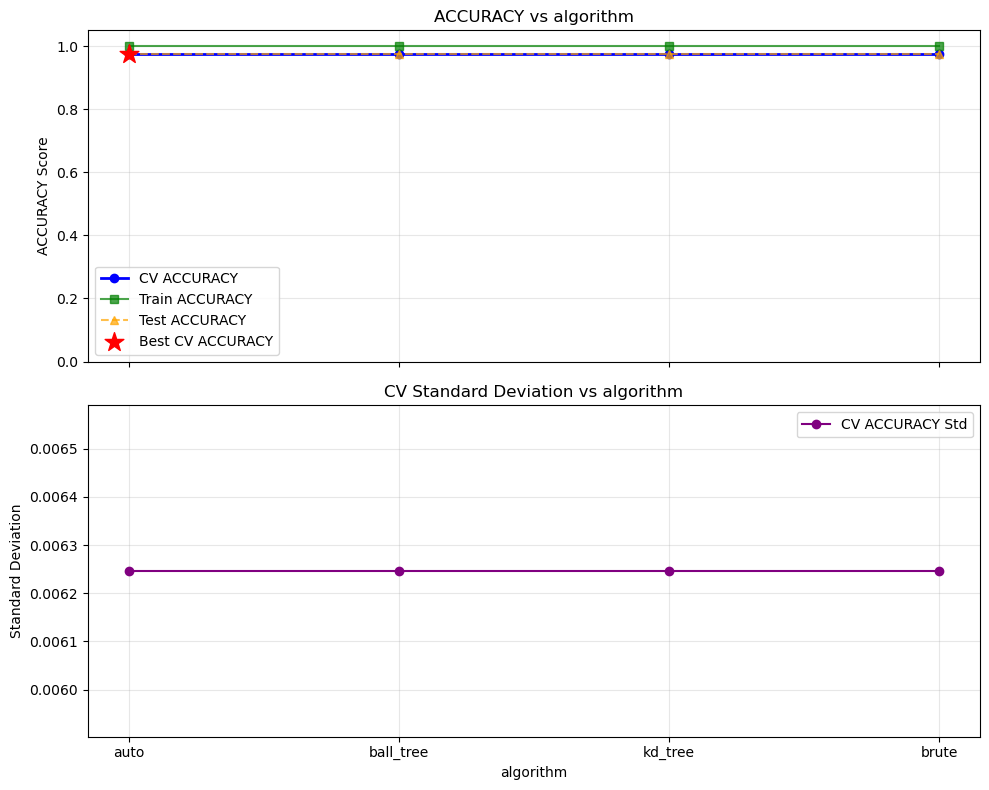

Execution Time: 00:00:00
Best algorithm: auto
Best CV accuracy: 0.9741
Best KNN parameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'manhattan', 'leaf_size': 10, 'algorithm': 'auto'}, Best F1 Score: 0.9741


In [217]:
algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']
best_params, best_score = sweep_classifier_parameter(
    model=next_model,
    Parameters=best_params,
    param='algorithm',
    parameter_list=algorithms,
    X_train=X_param_train, 
    y_train=y_param_train,
    X_test=X_param_val,
    y_test=y_param_val,
    n_repeats=5,
    verbose=True,
    return_score=True
)
print(f"Best KNN parameters: {best_params}, Best F1 Score: {best_score:.4f}")
next_model = KNeighborsClassifier(**best_params)

In [218]:
best_params

{'n_neighbors': 1,
 'weights': 'uniform',
 'metric': 'manhattan',
 'leaf_size': 10,
 'algorithm': 'auto'}

In [222]:
final_model = KNeighborsClassifier(**best_params)
final_model.fit(X_param_train, y_param_train)
y_holdout_pred = final_model.predict(X_holdout_scaled)
print(confusion_matrix(y_holdout, y_holdout_pred))

[[53206  1338]
 [    6     0]]


In [183]:
from sklearn.preprocessing import StandardScaler
final_model = KNeighborsClassifier(n_neighbors=5)

scaler = StandardScaler()
X_holdout_scaled = scaler.fit_transform(X_holdout)
# Fit the final model on the entire resampled training set
final_model.fit(X_train_values, y_train_resampled)

# Evaluate on holdout set
holdout_preds = final_model.predict(X_holdout_scaled)
holdout_accuracy = (holdout_preds == y_holdout).mean()
holdout_confusion = confusion_matrix(y_holdout, holdout_preds)
print(f"Holdout Set Accuracy: {holdout_accuracy:.4f}")
print("Holdout Confusion Matrix:")
print(holdout_confusion)

ValueError: X has 40 features, but KNeighborsClassifier is expecting 83 features as input.

In [192]:
y_proba_holdout = final_model.predict_proba(X_holdout_scaled)[:, 1]
print(f"Probability scores for the 6 actual concussions:")
print(y_proba_holdout[y_holdout == 1])

Probability scores for the 6 actual concussions:
[0.8 0.4 0.  0.  0.  0. ]


In [72]:
# Check what's different from your first successful run
print("Current model parameters:")
print(final_model.get_params())

print("\nFeature shapes:")
print(f"Current training features: {X_train_values.shape}")
print(f"Current holdout features: {X_holdout_scaled.shape}")

# Try the simple baseline from your first run
simple_knn = KNeighborsClassifier(n_neighbors=5)  # Same as your first run
simple_knn.fit(X_train_values, y_train_resampled)

y_simple_proba = simple_knn.predict_proba(X_holdout_scaled)[:, 1]
print(f"\nSimple KNN (k=5) probabilities for concussions:")
print(y_simple_proba[y_holdout == 1])

Current model parameters:
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}

Feature shapes:
Current training features: (2860, 40)
Current holdout features: (54550, 40)

Simple KNN (k=5) probabilities for concussions:
[0.  0.2 0.  0.  0.  0. ]


In [73]:
# Compare the actual concussion cases in your holdout sets
print("Current holdout concussion count:", sum(y_holdout))

# If you saved your original splits, load them:
try:
    y_holdout_original = pd.read_csv('motion_holdout_y.csv')['concussed']
    print("Original holdout concussion count:", sum(y_holdout_original))
    
    # Are they the same holdout set?
    if len(y_holdout) == len(y_holdout_original):
        print("Same holdout size, checking if same splits...")
        print("Identical holdout sets:", np.array_equal(y_holdout, y_holdout_original))
    
except:
    print("Original holdout not available for comparison")

Current holdout concussion count: 6
Original holdout concussion count: 6
Same holdout size, checking if same splits...
Identical holdout sets: True


In [74]:
# Compare training sets
try:
    X_train_original = pd.read_csv('motion_train_X_resampled.csv')
    y_train_original = pd.read_csv('motion_train_y_resampled.csv')['concussed']
    
    print("Training set comparison:")
    print(f"Original training shape: {X_train_original.shape}")
    print(f"Current training shape: {X_train_values.shape}")
    print(f"Original class distribution: {pd.Series(y_train_original).value_counts()}")
    print(f"Current class distribution: {pd.Series(y_train_resampled).value_counts()}")
    
    # Check if training data is identical
    if X_train_original.shape == X_train_values.shape:
        print("Training features identical:", np.allclose(X_train_original.values, X_train_values, equal_nan=True))
        print("Training labels identical:", np.array_equal(y_train_original, y_train_resampled))
    
except Exception as e:
    print(f"Can't load original training data: {e}")

Training set comparison:
Original training shape: (2860, 40)
Current training shape: (2860, 40)
Original class distribution: concussed
0    2600
1     260
Name: count, dtype: int64
Current class distribution: concussed
0    2600
1     260
Name: count, dtype: int64
Training features identical: True
Training labels identical: True


In [75]:
# Compare scaling between runs
print("Current feature statistics:")
print(f"Training mean: {X_train_values.mean():.6f}, std: {X_train_values.std():.6f}")
print(f"Holdout mean: {X_holdout_scaled.mean():.6f}, std: {X_holdout_scaled.std():.6f}")

# Check if features are in same order
print(f"First few training features: {X_train_values[0, :5]}")
print(f"First few holdout features: {X_holdout_scaled[0, :5]}")

Current feature statistics:
Training mean: 0.013999, std: 0.996986
Holdout mean: 1.327832, std: 4.839868
First few training features: [-0.25423813 -0.29640985 -0.15259297 -0.07912493 -0.38445678]
First few holdout features: [-0.09738302  0.00612737 -0.03279527 -0.3940365  -0.45552386]


In [76]:
# Your holdout data wasn't scaled properly
# Let's fix it:

# Load the raw holdout data (before scaling)
X_holdout_raw = pd.read_csv('motion_holdout_X.csv').values

# Apply the same scaler that was fitted on training data
scaler = joblib.load('motion_scaler.pkl')
X_holdout_properly_scaled = scaler.transform(X_holdout_raw)

print("Fixed scaling check:")
print(f"Holdout mean after proper scaling: {X_holdout_properly_scaled.mean():.6f}")
print(f"Holdout std after proper scaling: {X_holdout_properly_scaled.std():.6f}")

# Now test with properly scaled data
y_fixed_proba = final_model.predict_proba(X_holdout_properly_scaled)[:, 1]
print(f"\nProbabilities for concussions with PROPER scaling:")
print(y_fixed_proba[y_holdout == 1])

Fixed scaling check:
Holdout mean after proper scaling: 1.327832
Holdout std after proper scaling: 4.839868

Probabilities for concussions with PROPER scaling:
[0.  0.2 0.  0.  0.  0. ]


In [77]:
# Inspect what the scaler thinks it should do
print("Scaler parameters:")
print(f"Scaler mean: {scaler.mean_[:5]}")  # First 5 features
print(f"Scaler scale: {scaler.scale_[:5]}")  # First 5 features

# Check what the scaler was actually fitted on
print(f"\nScaler expects {len(scaler.mean_)} features")
print(f"Holdout has {X_holdout_raw.shape[1]} features")

# Manually check scaling
X_manual_scaled = (X_holdout_raw - scaler.mean_) / scaler.scale_
print(f"\nManual scaling check:")
print(f"Manual scaled mean: {X_manual_scaled.mean():.6f}")
print(f"Manual scaled std: {X_manual_scaled.std():.6f}")

Scaler parameters:
Scaler mean: [0.18672965 0.1540886  0.17547511 0.20507564 0.24114649]
Scaler scale: [0.22313589 0.14874203 0.16694806 0.19052967 0.21106794]

Scaler expects 40 features
Holdout has 40 features

Manual scaling check:
Manual scaled mean: 1.327832
Manual scaled std: 4.839868


In [78]:
# Maybe the training data wasn't properly scaled either?
# Let's see what happens if we re-scale the training data properly
X_train_raw = pd.read_csv('motion_train_X_resampled.csv').values

# Refit scaler on training data
from sklearn.preprocessing import StandardScaler
new_scaler = StandardScaler()
X_train_rescaled = new_scaler.fit_transform(X_train_raw)
X_holdout_rescaled = new_scaler.transform(X_holdout_raw)

print(f"\nWith fresh scaler:")
print(f"Training mean: {X_train_rescaled.mean():.6f}, std: {X_train_rescaled.std():.6f}")
print(f"Holdout mean: {X_holdout_rescaled.mean():.6f}, std: {X_holdout_rescaled.std():.6f}")

# Test with fresh scaling
retrained_model = KNeighborsClassifier(n_neighbors=5)
retrained_model.fit(X_train_rescaled, y_train_resampled)
y_fresh_proba = retrained_model.predict_proba(X_holdout_rescaled)[:, 1]
print(f"\nProbabilities with fresh scaling:")
print(y_fresh_proba[y_holdout == 1])


With fresh scaler:
Training mean: -0.000000, std: 1.000000
Holdout mean: 67.960960, std: 86.168289

Probabilities with fresh scaling:
[0. 0. 0. 0. 0. 0.]


In [79]:
# Compare raw data ranges
print("Raw data comparison:")
print(f"Training data range: {X_train_raw.min():.3f} to {X_train_raw.max():.3f}")
print(f"Holdout data range: {X_holdout_raw.min():.3f} to {X_holdout_raw.max():.3f}")

# Check first few rows of each to see if they look similar
print(f"\nTraining first row: {X_train_raw[0, :5]}")
print(f"Holdout first row: {X_holdout_raw[0, :5]}")

# Check if column names/order are the same
train_cols = pd.read_csv('motion_train_X_resampled.csv').columns
holdout_cols = pd.read_csv('motion_holdout_X.csv').columns
print(f"\nColumn names match: {list(train_cols) == list(holdout_cols)}")
print(f"First 5 training columns: {list(train_cols[:5])}")
print(f"First 5 holdout columns: {list(holdout_cols[:5])}")

Raw data comparison:
Training data range: -2.980 to 10.259
Holdout data range: -14.688 to 359.990

Training first row: [-0.25423813 -0.29640985 -0.15259297 -0.07912493 -0.38445678]
Holdout first row: [0.165      0.155      0.17       0.13       0.14500001]

Column names match: True
First 5 training columns: ['dis_slice_0', 'dis_slice_1', 'dis_slice_2', 'dis_slice_3', 'dis_slice_4']
First 5 holdout columns: ['dis_slice_0', 'dis_slice_1', 'dis_slice_2', 'dis_slice_3', 'dis_slice_4']


In [194]:
# Load the ORIGINAL training data (before resampling and scaling)
X_train_original_raw = pd.read_csv('scripts/punt_analytics/motion_train_X_original.csv').values
X_holdout_raw = pd.read_csv('scripts/punt_analytics/motion_holdout_X.csv').values

print("Original training data check:")
print(f"Original training range: {X_train_original_raw.min():.3f} to {X_train_original_raw.max():.3f}")
print(f"Original training first row: {X_train_original_raw[0, :5]}")

# Now both should be on the same scale - fit fresh scaler
fresh_scaler = StandardScaler()
X_train_fresh_scaled = fresh_scaler.fit_transform(X_train_original_raw)
X_holdout_fresh_scaled = fresh_scaler.transform(X_holdout_raw)

print(f"\nWith matching raw data:")
print(f"Training mean: {X_train_fresh_scaled.mean():.6f}, std: {X_train_fresh_scaled.std():.6f}")
print(f"Holdout mean: {X_holdout_fresh_scaled.mean():.6f}, std: {X_holdout_fresh_scaled.std():.6f}")

# Need to re-apply SMOTE to the properly scaled data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Load original labels
y_train_original = pd.read_csv('scripts/punt_analytics/motion_train_y_original.csv')['concussed']

# Apply SMOTE to the freshly scaled data
undersample = RandomUnderSampler(sampling_strategy=0.01)
oversample = SMOTE(sampling_strategy=0.1)
pipeline = ImbPipeline([('undersample', undersample), ('oversample', oversample)])

X_train_resampled_fresh, y_train_resampled_fresh = pipeline.fit_resample(X_train_fresh_scaled, y_train_original)

# Train model on properly processed data
fresh_model = KNeighborsClassifier(n_neighbors=5)
fresh_model.fit(X_train_resampled_fresh, y_train_resampled_fresh)

# Test on properly scaled holdout
y_final_proba = fresh_model.predict_proba(X_holdout_fresh_scaled)[:, 1]
print(f"\nFinal probabilities for concussions:")
print(y_final_proba[y_holdout == 1])

Original training data check:
Original training range: -17.160 to 359.980
Original training first row: [0.31636363 0.43800002 0.43699998 0.372      0.36799997]

With matching raw data:
Training mean: 0.000000, std: 1.000000
Holdout mean: 0.000436, std: 1.000054

Final probabilities for concussions:
[0.8 0.  0.2 0.  0.  0.2]


In [195]:
confusion_matrix = confusion_matrix(y_holdout, fresh_model.predict(X_holdout_fresh_scaled))
print("Final confusion matrix on holdout set:")
print(confusion_matrix)

Final confusion matrix on holdout set:
[[52727  1817]
 [    5     1]]
